# Analysis of Osmotic Stress RNA-seq data

This document is a reproducible record of the various steps in the analysis of osmotic stress RNA-seq data for RPE-1 cells.

## Necessary Modules and R Packages

Apart from `r-base` and `r-essentials` set of packages the following sets of additional packages are necessary.

- NMF
- ggplot2
- locfit (there may be some complexities in anaconda install)

From [Bioconductor](https://bioconductor.org) the following are needed (installed with `BiocManager::install()`)

- DESeq2
- limma
- vsn
- gplots

## Load relevant libraries

First we will load the necessary libraries as below

In [1]:
Libraries <- c("limma","vsn","gplots","ggplot2","DESeq2","stringr")
suppressMessages(lapply(Libraries, require, character.only=T))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

## Loading Count Data

Next we will load the count data from the tab separated file as below and inspect it. Then we will rename the rows based on gene ID.

In [2]:
read.counts <- read.table("gene_expression_organized_2.txt", sep = "", header = T)
head(read.counts)

st_gene_id,gene_id,gene_symbol,read_count_Media_0h_1,read_count_Media_0h_2,read_count_Media_0h_3,read_count_Media_6h_1,read_count_Media_6h_2,read_count_Media_6h_3,read_count_Media_12h_1,...,read_count_Hyper_12h_3,read_count_Hyper_24h_1,read_count_Hyper_24h_2,read_count_Hyper_24h_3,read_count_Hyper_48h_1,read_count_Hyper_48h_2,read_count_Hyper_48h_3,read_count_Hyper_72h_1,read_count_Hyper_72h_2,read_count_Hyper_72h_3
G9606_9266,2323,FLT3LG,273,292.0,221,218,207,219,267,...,276,350,307,298,244,342,235,291,260.00,325
G9606_9392,90459,ERI1,535,611.0,520,590,539,526,570,...,401,507,486,378,507,425,511,339,366.00,334
G9606_4009,79595,SAP130,3580,4097.0,3234,3931,4068,3823,4216,...,3136,3152,3098,2977,3611,3324,3384,2956,2775.00,2763
G9606_24999,100129098,LOC100129098,0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0
G9606_4181,10927,SPIN1,1809,1690.0,1607,2423,1866,1927,2343,...,2636,2022,1906,1731,2707,2232,2312,2084,2193.00,1778
G9606_16727,8879,SGPL1,1619,1526.1,1642,1636,1613,1526,1719,...,1911,1634,1604,1450,1779,1359,1418,1634,1480.99,1519


## Preprocess the data

Next we will remove some of the duplicate gene names in the data and assign the rownames to the table. We will also remove the non-numerical data so that we can import it directly to DESeq.

In [3]:
read.counts <- read.counts[!duplicated(read.counts$gene_symbol),]

In [4]:
row.names(read.counts) <- read.counts$gene_symbol

In [5]:
read.counts <- read.counts[,-c(1:3)]
head(read.counts)

,read_count_Media_0h_1,read_count_Media_0h_2,read_count_Media_0h_3,read_count_Media_6h_1,read_count_Media_6h_2,read_count_Media_6h_3,read_count_Media_12h_1,read_count_Media_12h_2,read_count_Media_12h_3,read_count_Media_24h_1,...,read_count_Hyper_12h_3,read_count_Hyper_24h_1,read_count_Hyper_24h_2,read_count_Hyper_24h_3,read_count_Hyper_48h_1,read_count_Hyper_48h_2,read_count_Hyper_48h_3,read_count_Hyper_72h_1,read_count_Hyper_72h_2,read_count_Hyper_72h_3
FLT3LG,273,292.0,221,218,207,219,267,207,206,233,...,276,350,307,298,244,342,235,291,260.00,325
ERI1,535,611.0,520,590,539,526,570,474,531,577,...,401,507,486,378,507,425,511,339,366.00,334
SAP130,3580,4097.0,3234,3931,4068,3823,4216,4030,3418,3635,...,3136,3152,3098,2977,3611,3324,3384,2956,2775.00,2763
LOC100129098,0,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0
SPIN1,1809,1690.0,1607,2423,1866,1927,2343,2001,1988,2393,...,2636,2022,1906,1731,2707,2232,2312,2084,2193.00,1778
SGPL1,1619,1526.1,1642,1636,1613,1526,1719,1493,1579,1422,...,1911,1634,1604,1450,1779,1359,1418,1634,1480.99,1519


## Preparation for DESeq Analysis

Next we have to prepare the data for analysis using `DESeq2`. For this first we have to modify the names of the columns and create a factor vector from the column names

In [6]:
read.counts.orig.names <- names(read.counts)
names(read.counts) <- gsub("read_count_(.*)", "\\1", read.counts.orig.names)
names(read.counts)[1:5]

[1] "Media_0h_1" "Media_0h_2" "Media_0h_3" "Media_6h_1" "Media_6h_2"

## Creating condition vectors for samples and time

The next step is to create separate condition vectors for different samples (osmolarity) and time intervals

In [7]:
sample_info <- data.frame(condition = gsub("([A-Za-z]+)_.*", "\\1", names(read.counts)), row.names = names(read.counts))
sample_info[1:5,]

[1] Media Media Media Media Media
Levels: Hyper Hypo Iso Media

In [8]:
#Time information
time_info <- data.frame(condition = gsub("[A-Za-z]+_([0-9]+h)_[0-9]", "\\1", names(read.counts)), row.names = names(read.counts))
time_info[1:5,]

[1] 0h 0h 0h 6h 6h
Levels: 0h 12h 24h 48h 6h 72h

## Import Data to DESeq2 and inspect

Next we are ready to import the data using DESeq2 and inspect to make sure that the import is successful.

In [9]:
DESeq.ds <- DESeqDataSetFromMatrix(countData=round(read.counts), colData=sample_info, design = ~ condition)
head(colData(DESeq.ds))
head(rowData(DESeq.ds))
head(assay(DESeq.ds, "counts"))

converting counts to integer mode


DataFrame with 6 rows and 1 column
           condition
            <factor>
Media_0h_1     Media
Media_0h_2     Media
Media_0h_3     Media
Media_6h_1     Media
Media_6h_2     Media
Media_6h_3     Media

DataFrame with 6 rows and 0 columns

,Media_0h_1,Media_0h_2,Media_0h_3,Media_6h_1,Media_6h_2,Media_6h_3,Media_12h_1,Media_12h_2,Media_12h_3,Media_24h_1,...,Hyper_12h_3,Hyper_24h_1,Hyper_24h_2,Hyper_24h_3,Hyper_48h_1,Hyper_48h_2,Hyper_48h_3,Hyper_72h_1,Hyper_72h_2,Hyper_72h_3
FLT3LG,273,292,221,218,207,219,267,207,206,233,...,276,350,307,298,244,342,235,291,260,325
ERI1,535,611,520,590,539,526,570,474,531,577,...,401,507,486,378,507,425,511,339,366,334
SAP130,3580,4097,3234,3931,4068,3823,4216,4030,3418,3635,...,3136,3152,3098,2977,3611,3324,3384,2956,2775,2763
LOC100129098,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SPIN1,1809,1690,1607,2423,1866,1927,2343,2001,1988,2393,...,2636,2022,1906,1731,2707,2232,2312,2084,2193,1778
SGPL1,1619,1526,1642,1636,1613,1526,1719,1493,1579,1422,...,1911,1634,1604,1450,1779,1359,1418,1634,1481,1519


In [10]:
colData(DESeq.ds) <- cbind(colData(DESeq.ds), time_info)
colData(DESeq.ds)

DataFrame with 63 rows and 2 columns
            condition condition
             <factor>  <factor>
Media_0h_1      Media        0h
Media_0h_2      Media        0h
Media_0h_3      Media        0h
Media_6h_1      Media        6h
Media_6h_2      Media        6h
...               ...       ...
Hyper_48h_2     Hyper       48h
Hyper_48h_3     Hyper       48h
Hyper_72h_1     Hyper       72h
Hyper_72h_2     Hyper       72h
Hyper_72h_3     Hyper       72h

## Normalization of counts

Next is the important step of normalization of counts. To do this we will first remove any gene with zero counts and then check to make sure that column counts are consistent.

In [11]:
DESeq.ds <- DESeq.ds[ rowSums(counts(DESeq.ds)) > 0, ]
DESeq.ds <- na.omit(DESeq.ds)
colSums(counts(DESeq.ds))[1:5]

Media_0h_1 Media_0h_2 Media_0h_3 Media_6h_1 Media_6h_2 
  23901972   26467277   25765136   26704361   26620553

To perform the normalization we will first use `estimateSizeFactors` from DESeq2 and then use `counts()` to normalize it. Finally we will do a log2 transform

In [13]:
DESeq.ds <- estimateSizeFactors(DESeq.ds)
counts.sf_normalized <- counts(DESeq.ds, normalized=T)
log.norm.counts <- log2(counts.sf_normalized + 1)

Next we can visualize the unnormalized and normalized data to make sure that normalization was done properly

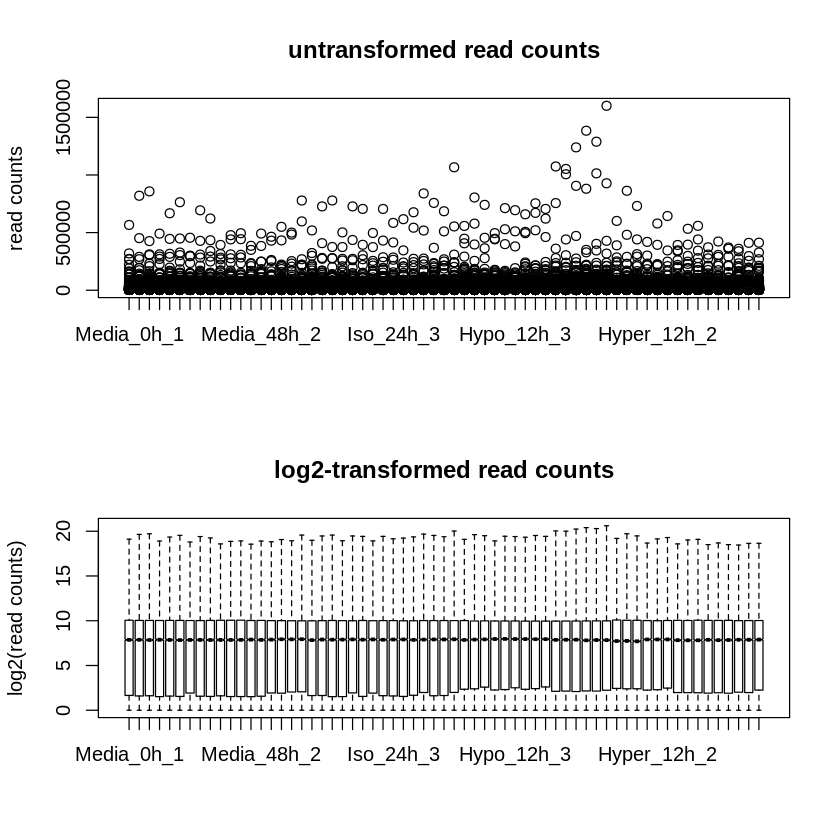

In [15]:
par(mfrow=c(2,1))
boxplot(counts.sf_normalized, notch=T, main="untransformed read counts", ylab="read counts")
boxplot(log.norm.counts, notch=T, main="log2-transformed read counts", ylab="log2(read counts)")

## Visual Exploration and Homoskedasticity Test

Next we will explore the data visually by doing pairwise plots to make sure the read counts are similar between replicates. Also we will do a `meanSdplot()` to check the homoskedasticity of the data (i.e. all variables have similar variance)

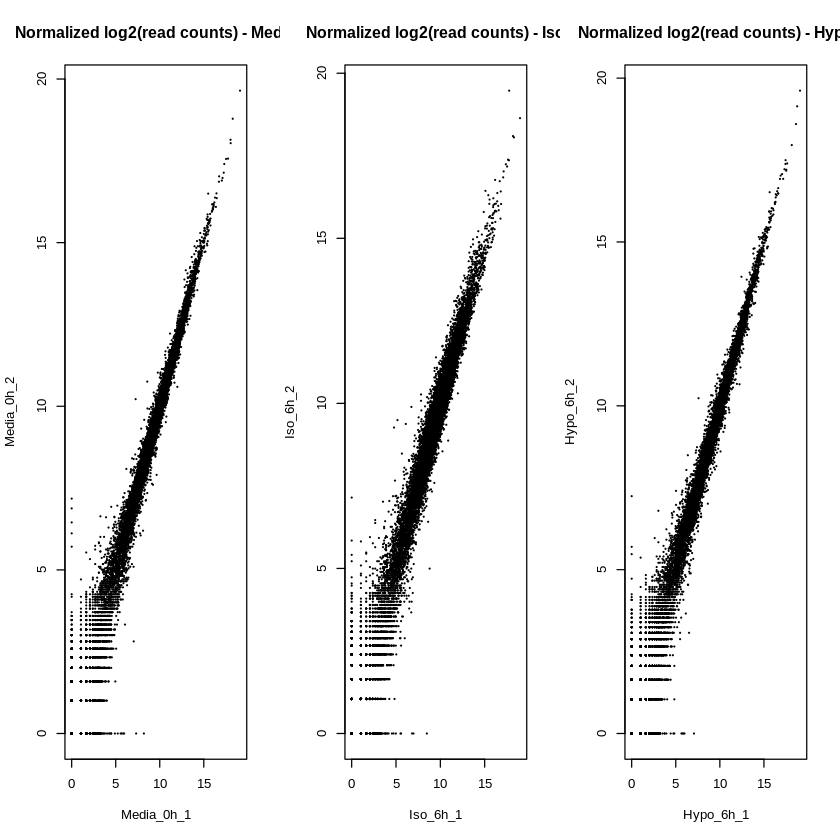

In [16]:
par(mfrow = c(1,3))
plot(log.norm.counts[,1:2], cex=.1, main = "Normalized log2(read counts) - Media")
plot(log.norm.counts[,19:20], cex=.1, main = "Normalized log2(read counts) - Iso")
plot(log.norm.counts[,34:35], cex=.1, main = "Normalized log2(read counts) - Hypo")

Next we can plot the `meanSdplot()` as below with `ggplot2`

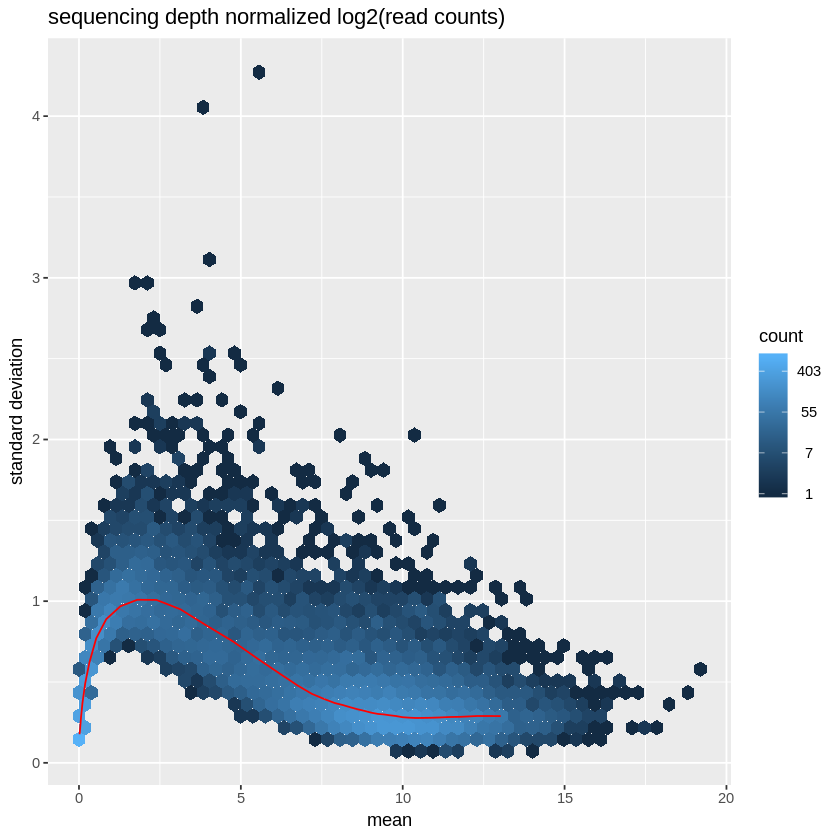

In [17]:
msd_plot <- meanSdPlot(log.norm.counts, ranks=F, plot=F)
msd_plot$gg + ggtitle("sequencing depth normalized log2(read counts)") + ylab("standard deviation")

## Decreasing heteroskedasticity

As we can see from the plot above the counts are indeed very heteroskedastic. The `rlog()` function in DESeq2 returns values that are both normalized for sequencing depth and transformed to log scale. So we can use this for our purpose.

In [19]:
DESeq.rlog <- rlog(DESeq.ds, blind=T)
rlog.norm.counts <- assay(DESeq.rlog)

rlog() may take a long time with 50 or more samples,
vst() is a much faster transformation


In [20]:
colnames(colData(DESeq.rlog))[1] <- "Treatment"
colnames(colData(DESeq.rlog))[2] <- "Time"

Now we can plot the meanSdplot as before and compare with the previous data

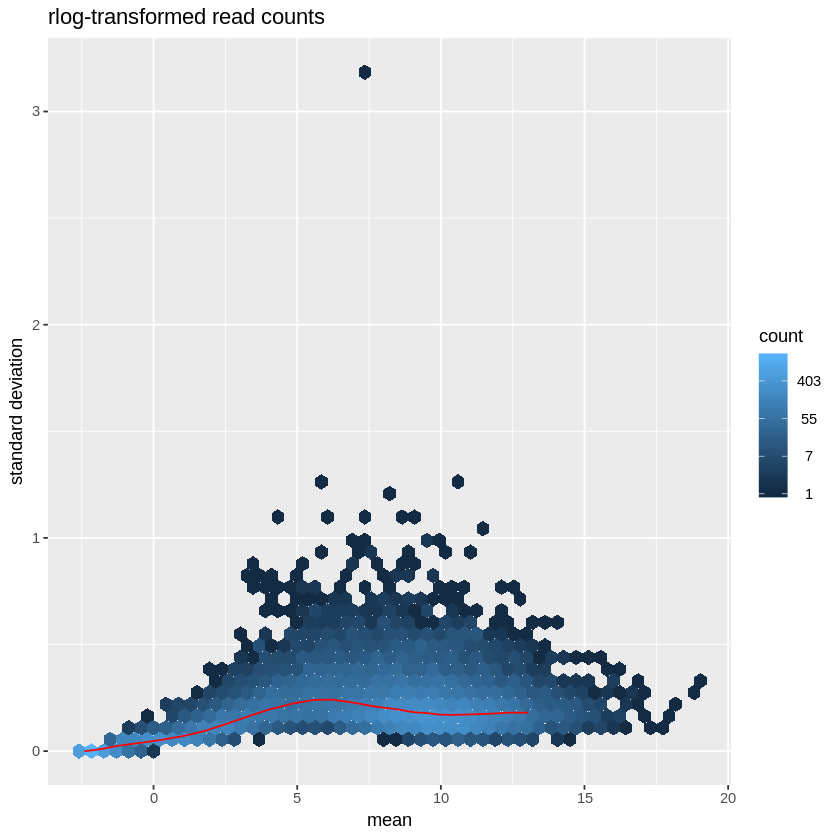

In [21]:
msd_plot2 <- meanSdPlot(rlog.norm.counts, ranks=F, plot=F)
msd_plot2$gg + ggtitle("rlog-transformed read counts") + ylab("standard deviation")

We can see from the plot above that the above operations have reduced heteroskedasticity of data. So we will now use this transformed data for our analysis.

## Correlation Analysis and Clustering

Next we can do a simple correlation analysis and generate simple cluster diagram to identify any association between the mediums of different osmolarities.

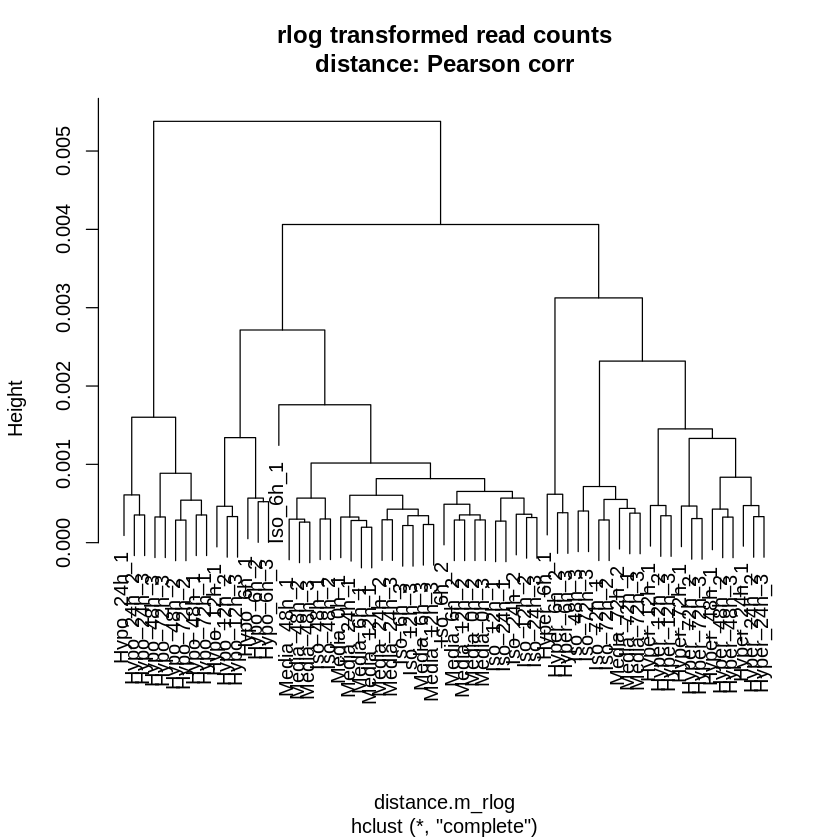

In [22]:
distance.m_rlog <- as.dist(1 - cor(rlog.norm.counts, method="pearson"))
plot(hclust(distance.m_rlog), labels=colnames(rlog.norm.counts), main = "rlog transformed read counts\ndistance: Pearson corr")

## Principal Components Analysis

Next we can perform Principal Components analysis to identify if groups of genes have something in common. This can be done most easily with `plotPCA()` function in `ggplot2` for a DESeq2

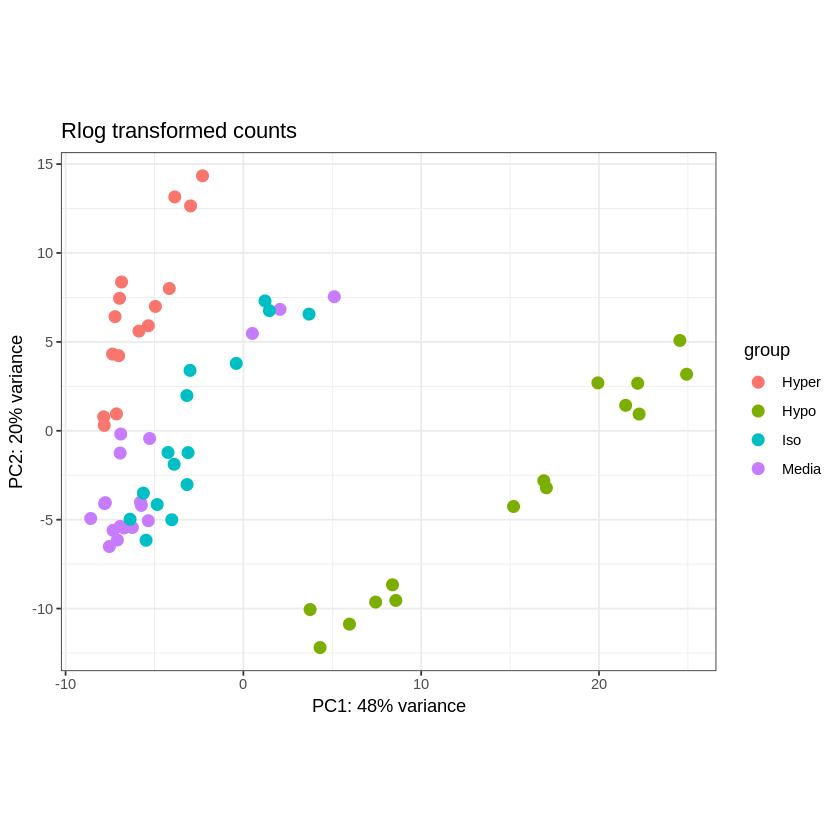

In [23]:
#Collapsed components
P <- plotPCA(DESeq.rlog, "Treatment")
P <- P + theme_bw() + ggtitle("Rlog transformed counts")
print(P)

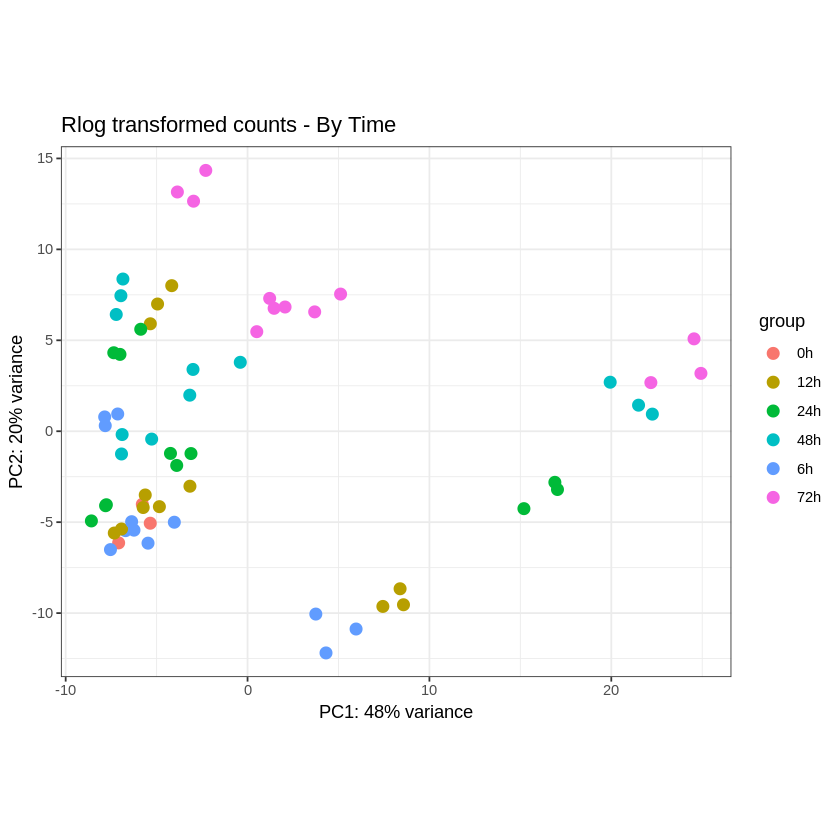

In [24]:
#PCA by time
#Collapsed components
P.time <- plotPCA(DESeq.rlog, "Time")
P.time <- P.time + theme_bw() + ggtitle("Rlog transformed counts - By Time")
print(P.time)

## Differential Gene Expression Analysis

Next we will perform a differential gene expression analysis between different samples and time points to identify list of genes of interest. We will use the `limma` package for this. But first we need to get the proper list of gene symbols

To use the `limma` package we have to first create a design matrix for different sample conditions.

In [25]:
treatment <- factor(colData(DESeq.rlog)[,1])
treatment

[1] Media Media Media Media Media Media Media Media Media Media Media Media
[13] Media Media Media Media Media Media Iso   Iso   Iso   Iso   Iso   Iso  
[25] Iso   Iso   Iso   Iso   Iso   Iso   Iso   Iso   Iso   Hypo  Hypo  Hypo 
[37] Hypo  Hypo  Hypo  Hypo  Hypo  Hypo  Hypo  Hypo  Hypo  Hypo  Hypo  Hypo 
[49] Hyper Hyper Hyper Hyper Hyper Hyper Hyper Hyper Hyper Hyper Hyper Hyper
[61] Hyper Hyper Hyper
Levels: Hyper Hypo Iso Media

In [27]:
timeinterval <- factor(colData(DESeq.rlog)[,2])
timeinterval

[1] 0h  0h  0h  6h  6h  6h  12h 12h 12h 24h 24h 24h 48h 48h 48h 72h 72h 72h 6h 
[20] 6h  6h  12h 12h 12h 24h 24h 24h 48h 48h 48h 72h 72h 72h 6h  6h  6h  12h 12h
[39] 12h 24h 24h 24h 48h 48h 48h 72h 72h 72h 6h  6h  6h  12h 12h 12h 24h 24h 24h
[58] 48h 48h 48h 72h 72h 72h
Levels: 0h 12h 24h 48h 6h 72h

In [28]:
design <- model.matrix(~treatment)
design.time <- model.matrix(~timeinterval)

### Separating data at different time points

Below we will separate the dataset for different time points at different osmolarity

In [29]:
rlog.norm.counts.6h <- rlog.norm.counts[,str_detect(colnames(rlog.norm.counts), "6h.*")]
rlog.norm.counts.12h <- rlog.norm.counts[,str_detect(colnames(rlog.norm.counts), "12h.*")]
rlog.norm.counts.24h <- rlog.norm.counts[,str_detect(colnames(rlog.norm.counts), "24h.*")]
rlog.norm.counts.48h <- rlog.norm.counts[,str_detect(colnames(rlog.norm.counts), "48h.*")]
rlog.norm.counts.72h <- rlog.norm.counts[,str_detect(colnames(rlog.norm.counts), "72h.*")]

In [31]:
colnames(rlog.norm.counts.6h)

[1] "Media_6h_1" "Media_6h_2" "Media_6h_3" "Iso_6h_1"   "Iso_6h_2"  
 [6] "Iso_6h_3"   "Hypo_6h_1"  "Hypo_6h_2"  "Hypo_6h_3"  "Hyper_6h_1"
[11] "Hyper_6h_2" "Hyper_6h_3"

### 6h post-stimulation

In [32]:
treatment.6h <- factor(gsub("([a-zA-Z]+)_6h_[0-9]","\\1",colnames(rlog.norm.counts.6h)))
treatment.6h

[1] Media Media Media Iso   Iso   Iso   Hypo  Hypo  Hypo  Hyper Hyper Hyper
Levels: Hyper Hypo Iso Media

In [34]:
design.6h <- model.matrix(~treatment.6h)

Next we can use the `lmFit` function for the fitting and `eBayes` for making an adjustment to the p-values based on Bayes criteria

In [35]:
fit.6h <- lmFit(rlog.norm.counts.6h, design.6h)
fit.6h <- eBayes(fit.6h)
topTable(fit.6h, coef=2, adjust="fdr", number=15)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
CYP2C9,-0.7966220,0.7802094,-103.45806,1.203807e-14,2.184188e-10,19.89332
IL1R2,-0.5143371,-0.0252524,-59.96839,1.318922e-12,1.196526e-08,18.01083
NSG2,-1.2520608,1.8440715,-54.34103,3.078682e-12,1.861987e-08,17.52608
CHRM5,1.2991740,2.5323780,52.49916,4.141438e-12,1.878556e-08,17.34558
INPP5J,-1.9537182,7.4262030,-43.04927,2.279226e-11,8.270856e-08,16.20037
FNDC7,-0.8089132,1.2595262,-41.46897,3.142256e-11,9.502182e-08,15.96506
NR2F1,-1.9496214,12.7231836,-38.59481,5.820126e-11,1.462542e-07,15.49688
TP53AIP1,-1.0003812,1.5301973,-38.13619,6.448600e-11,1.462542e-07,15.41695
NPC1L1,-0.7373491,1.2391626,-37.03654,8.287783e-11,1.670817e-07,15.21898
BHMG1,0.8654804,1.7050179,34.46489,1.535700e-10,2.479265e-07,14.71841


We can get the full list of genes and write it to an output file for future analysis

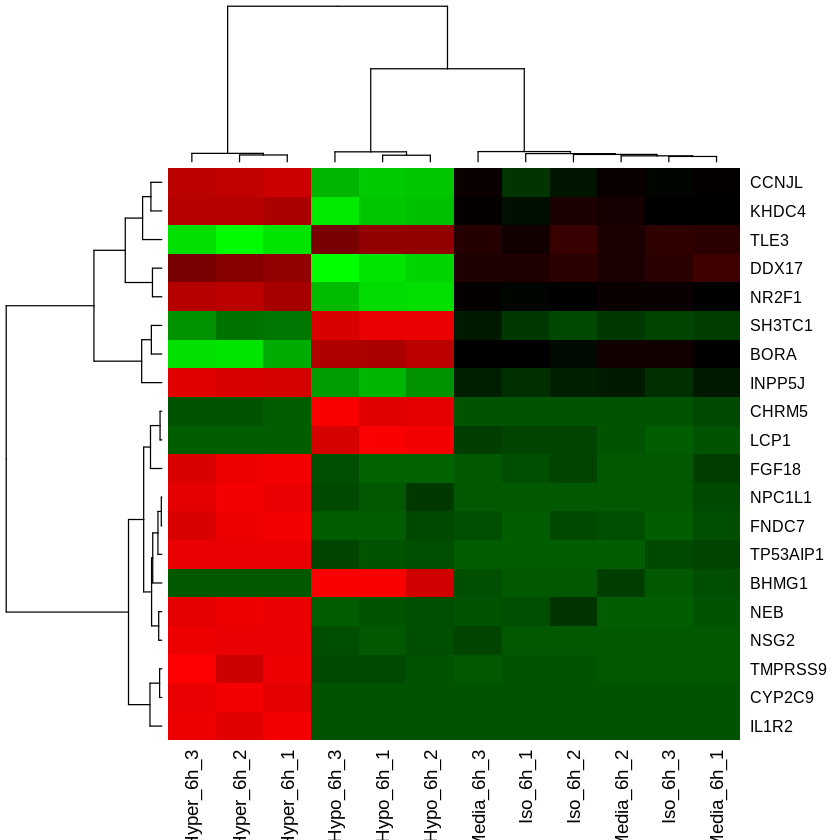

In [36]:
diffexpIDs <- as.character(rownames(topTable(fit.6h, coef=2, number=20)))
diffexprows <- which(rownames(rlog.norm.counts.6h) %in% diffexpIDs)
heatmap(rlog.norm.counts.6h[diffexprows,], col=greenred(100), Rowv=F, scale="row", labCol=colnames(rlog.norm.counts.6h))

### 12h post stimulation

In [38]:
treatment.12h <- factor(gsub("([a-zA-Z]+)_12h_[0-9]","\\1",colnames(rlog.norm.counts.12h)))
design.12h <- model.matrix(~treatment.12h)
fit.12h <- lmFit(rlog.norm.counts.12h, design.12h)
fit.12h <- eBayes(fit.12h)
topTable(fit.12h, coef=2, adjust="fdr", number=15)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
SMCO3,1.4194320,3.310075,70.33950,3.307434e-13,6.001008e-09,18.91928
TXNIP,2.9909968,10.420584,61.84075,1.002506e-12,9.094737e-09,18.34518
PNPLA6,-0.9734348,11.738813,-58.74133,1.560714e-12,9.439201e-09,18.09388
PDK1,1.7070344,8.727577,49.31066,7.034468e-12,3.190835e-08,17.14520
NOTUM,-1.8168021,3.799555,-38.99852,5.280493e-11,1.101801e-07,15.65966
INPPL1,-0.7236278,12.750925,-38.55916,5.819757e-11,1.101801e-07,15.58224
ATXN7L3,-0.8616148,11.084567,-38.45988,5.949948e-11,1.101801e-07,15.56456
SEC14L1,-0.8483780,11.778978,-38.29028,6.179946e-11,1.101801e-07,15.53418
CHPF2,-0.8917970,11.976725,-38.25950,6.222748e-11,1.101801e-07,15.52865
PRSS35,-1.6469476,3.145240,-38.20032,6.305953e-11,1.101801e-07,15.51799


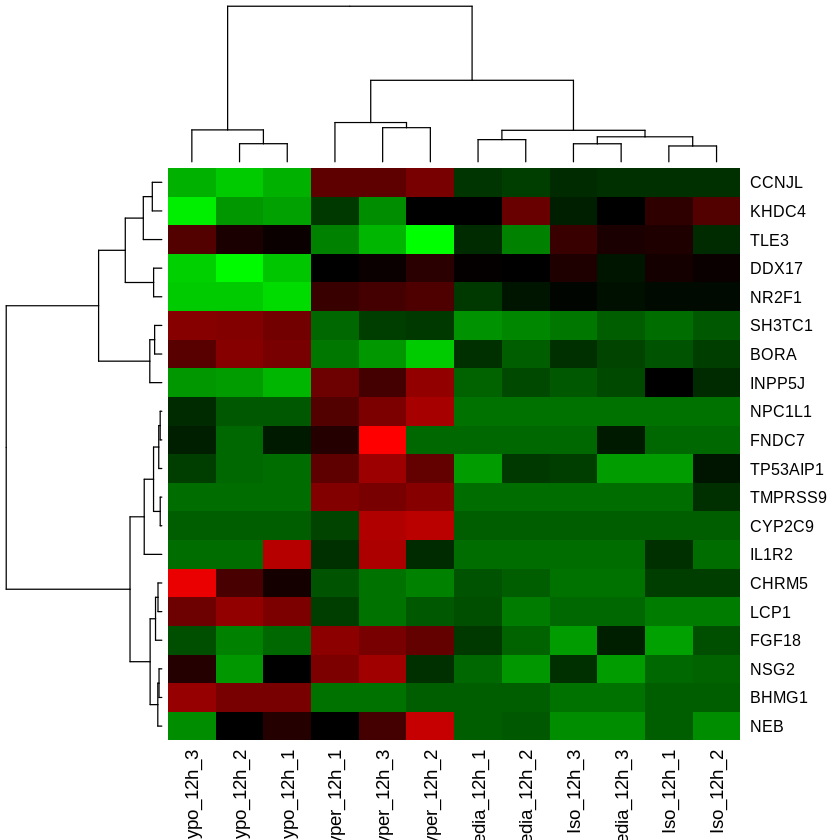

In [39]:
diffexpIDs.12h <- as.character(rownames(topTable(fit.12h, coef=2, number=20)))
diffexprows.12h <- which(rownames(rlog.norm.counts.12h) %in% diffexpIDs)
heatmap(rlog.norm.counts.12h[diffexprows,], col=greenred(100), Rowv=F, scale="row", labCol=colnames(rlog.norm.counts.12h))

### 24h post stimulation

In [40]:
treatment.24h <- factor(gsub("([a-zA-Z]+)_24h_[0-9]","\\1",colnames(rlog.norm.counts.24h)))
design.24h <- model.matrix(~treatment.24h)
fit.24h <- lmFit(rlog.norm.counts.24h, design.24h)
fit.24h <- eBayes(fit.24h)
topTable(fit.24h, coef=2, adjust="fdr", number=15)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
SMCO3,1.8756464,3.428408,75.66755,1.913804e-13,3.472405e-09,19.54309
TXNIP,3.7135051,10.425732,55.89416,2.574998e-12,2.336038e-08,18.05032
TONSL,-1.2009886,11.230232,-44.10268,1.961990e-11,9.935511e-08,16.59010
SDSL,2.5677863,7.563803,43.53921,2.190368e-11,9.935511e-08,16.50413
NGFR,7.7500580,7.739681,41.01892,3.649247e-11,1.108028e-07,16.09712
GNG2,2.0908381,9.648083,40.77788,3.838026e-11,1.108028e-07,16.05617
PLCD4,2.3752781,7.035216,39.37752,5.175610e-11,1.108028e-07,15.81072
SLC16A9,2.1241574,3.632097,39.00828,5.610009e-11,1.108028e-07,15.74380
TOMM40,-0.9733081,11.635538,-38.96108,5.668403e-11,1.108028e-07,15.73518
SLCO4A1,-1.3714216,9.739943,-38.62319,6.106855e-11,1.108028e-07,15.67300


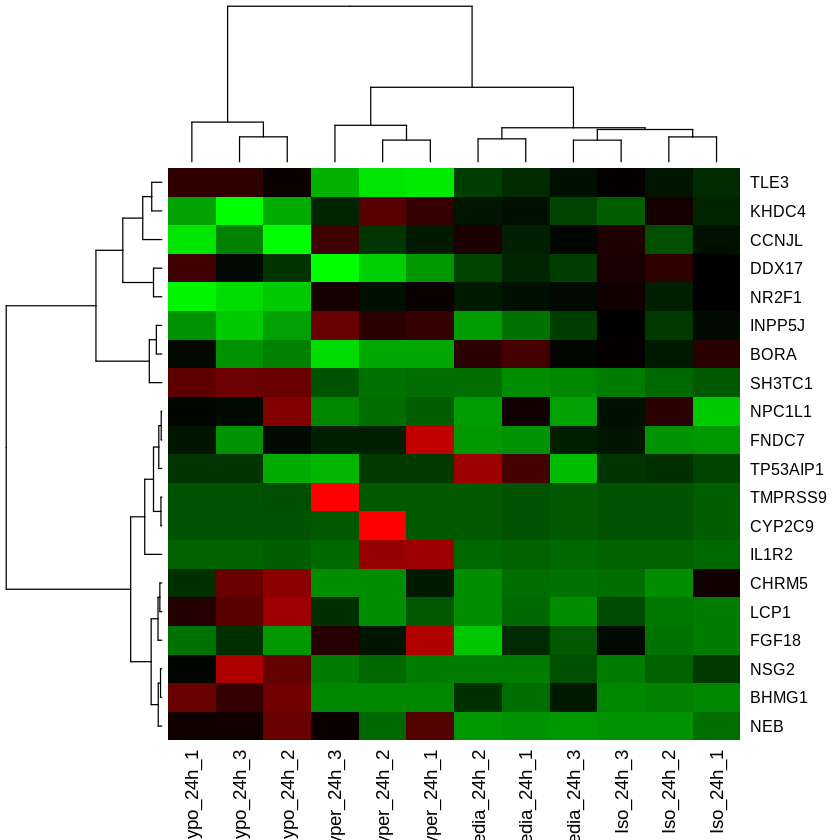

In [41]:
diffexpIDs.24h <- as.character(rownames(topTable(fit.24h, coef=2, number=20)))
diffexprows.24h <- which(rownames(rlog.norm.counts.24h) %in% diffexpIDs)
heatmap(rlog.norm.counts.24h[diffexprows,], col=greenred(100), Rowv=F, scale="row", labCol=colnames(rlog.norm.counts.24h))

### 48h post stimulation

In [42]:
treatment.48h <- factor(gsub("([a-zA-Z]+)_48h_[0-9]","\\1",colnames(rlog.norm.counts.48h)))
design.48h <- model.matrix(~treatment.48h)
fit.48h <- lmFit(rlog.norm.counts.48h, design.48h)
fit.48h <- eBayes(fit.48h)
topTable(fit.48h, coef=2, adjust="fdr", number=15)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
SLC16A9,2.3917684,3.670182,81.19304,1.072564e-13,1.946060e-09,19.88386
GNG2,2.2000222,9.607954,58.83986,1.696487e-12,1.140026e-08,18.36556
LAYN,-1.5722630,9.652199,-58.12092,1.884964e-12,1.140026e-08,18.29790
RRAS2,-1.0115746,10.491396,-47.57190,1.047759e-11,4.752634e-08,17.09984
CLU,2.0207337,9.481731,42.43982,2.782457e-11,1.009698e-07,16.34123
TRIM16,1.0339564,10.110176,41.34864,3.476630e-11,1.051333e-07,16.16106
JPH2,-2.1254574,7.902604,-40.45143,4.193806e-11,1.087034e-07,16.00739
SLCO4A1,-1.7333179,9.491273,-36.64273,9.761877e-11,1.970438e-07,15.29382
NEO1,1.6901478,7.676656,36.30704,1.055998e-10,1.970438e-07,15.22576
NGFR,8.4429311,7.691575,35.94888,1.149272e-10,1.970438e-07,15.15214


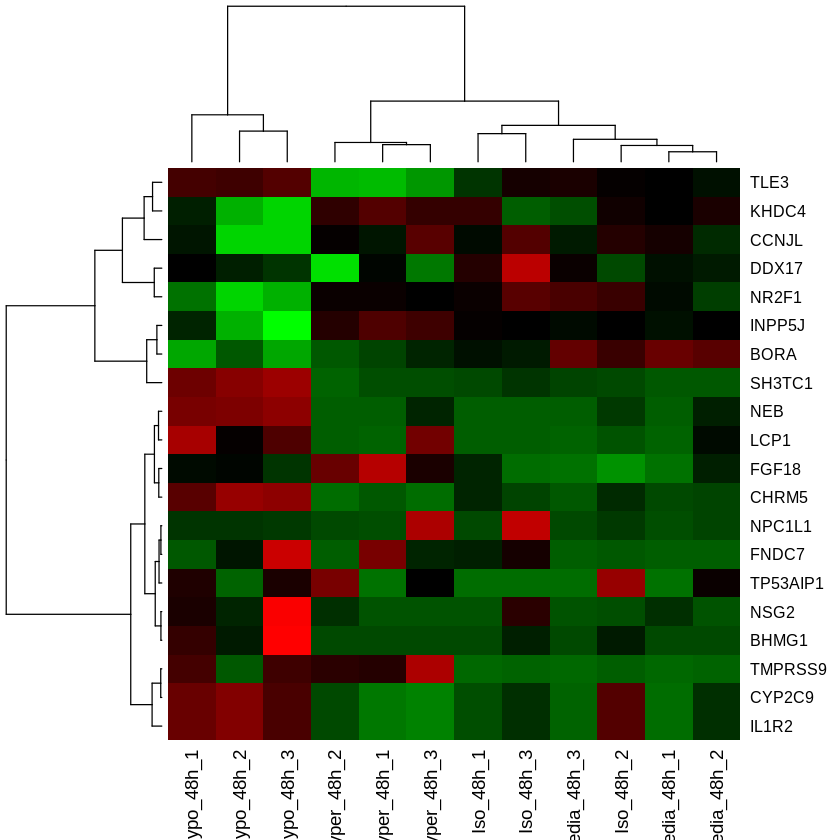

In [43]:
diffexpIDs.48h <- as.character(rownames(topTable(fit.48h, coef=2, number=20)))
diffexprows.48h <- which(rownames(rlog.norm.counts.48h) %in% diffexpIDs)
heatmap(rlog.norm.counts.48h[diffexprows,], col=greenred(100), Rowv=F, scale="row", labCol=colnames(rlog.norm.counts.48h))

### 72h post stimulation

In [44]:
treatment.72h <- factor(gsub("([a-zA-Z]+)_72h_[0-9]","\\1",colnames(rlog.norm.counts.72h)))
design.72h <- model.matrix(~treatment.72h)
fit.72h <- lmFit(rlog.norm.counts.72h, design.72h)
fit.72h <- eBayes(fit.72h)
topTable(fit.72h, coef=2, adjust="fdr", number=15)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
SLC16A9,2.4887295,3.688332,92.09852,3.507038e-14,6.363171e-10,19.65658
NGFR,8.8177634,7.834769,77.88717,1.480102e-13,1.342748e-09,19.12226
SMCO3,2.0992667,3.487688,51.76863,4.932493e-12,2.983172e-08,17.28485
LAYN,-1.8341105,9.751657,-44.96939,1.649117e-11,7.480393e-08,16.47092
MYCL,2.1788127,4.056523,41.82522,3.068176e-11,9.769769e-08,16.01792
SDSL,2.9089916,7.500108,41.25589,3.450208e-11,9.769769e-08,15.92979
CLCN3,0.7468667,10.381837,40.46509,4.071973e-11,9.769769e-08,15.80402
DSN1,-0.8793095,8.457372,-40.19997,4.307658e-11,9.769769e-08,15.76096
SLC16A6,2.8481677,6.057504,38.53490,6.186749e-11,1.247249e-07,15.47974
THOC6,-0.7548637,9.543742,-36.60290,9.605978e-11,1.742909e-07,15.12849


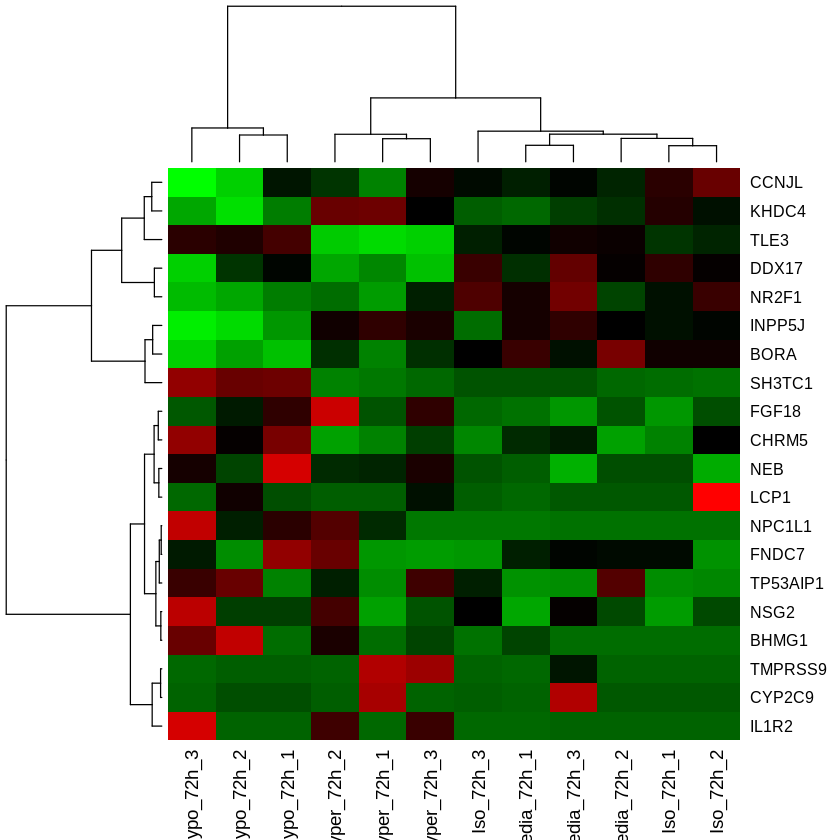

In [45]:
diffexpIDs.72h <- as.character(rownames(topTable(fit.72h, coef=2, number=20)))
diffexprows.72h <- which(rownames(rlog.norm.counts.72h) %in% diffexpIDs)
heatmap(rlog.norm.counts.72h[diffexprows,], col=greenred(100), Rowv=F, scale="row", labCol=colnames(rlog.norm.counts.72h))

### List of Differentially Expressed Genes

In [47]:
data.frame(t_6h=sort(diffexpIDs),t_12h=sort(diffexpIDs.12h),t_24=sort(diffexpIDs.24h),t_48h=sort(diffexpIDs.48h),t_72h=sort(diffexpIDs.72h))

t_6h,t_12h,t_24,t_48h,t_72h
BHMG1,AGFG2,BNIP3,CLU,AMTN
BORA,ARHGEF2,GEMIN4,GNG2,ANOS1
CCNJL,ATXN7L3,GNG2,GPC6,AP3B1
CHRM5,CCNJL,ICMT,JPH2,CLCN3
CYP2C9,CDK9,MAP6,LAYN,CLCN6
DDX17,CHPF2,NDRG1,MMP14,DSN1
FGF18,GLUD1,NGFR,NEO1,GPC6
FNDC7,INPPL1,PLCD4,NGFR,HIST1H2BK
IL1R2,NOTUM,S100A4,NSMCE1,KLHL9
INPP5J,PDK1,SDSL,OS9,LAYN


## Separating data at different osmolarity

In [48]:
rlog.norm.counts.Iso <- rlog.norm.counts[,str_detect(colnames(rlog.norm.counts), "Iso.*")]
rlog.norm.counts.Hypo <- rlog.norm.counts[,str_detect(colnames(rlog.norm.counts), "Hypo.*")]
rlog.norm.counts.Hyper <- rlog.norm.counts[,str_detect(colnames(rlog.norm.counts), "Hyper.*")]
rlog.norm.counts.Media <- rlog.norm.counts[,str_detect(colnames(rlog.norm.counts), "Media.*")]

In [49]:
colnames(rlog.norm.counts.Iso)

[1] "Iso_6h_1"  "Iso_6h_2"  "Iso_6h_3"  "Iso_12h_1" "Iso_12h_2" "Iso_12h_3"
 [7] "Iso_24h_1" "Iso_24h_2" "Iso_24h_3" "Iso_48h_1" "Iso_48h_2" "Iso_48h_3"
[13] "Iso_72h_1" "Iso_72h_2" "Iso_72h_3"

### Isotonic Media

In [52]:
treatment.Iso <- factor(gsub("Iso_([0-9]+h)_[0-9]","\\1",colnames(rlog.norm.counts.Iso)), 
                        levels=c("6h","12h","24h","48h","72h"))
design.Iso <- model.matrix(~treatment.Iso)
fit.Iso <- lmFit(rlog.norm.counts.Iso, design.Iso)
fit.Iso <- eBayes(fit.Iso)
topTable(fit.Iso, coef=2, adjust="fdr", number=15)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
NCCRP1,-0.03527184,-0.2169998,-12.501240,1.144413e-07,0.002076424,8.176053561
CLEC4M,0.01937904,-1.6268842,7.151757,2.308614e-05,0.209437452,3.089415953
MMP3,-0.06599393,-0.5956843,-6.327204,6.719406e-05,0.389320669,2.015991876
LMNTD1,0.16460571,1.1387815,6.087925,9.313852e-05,0.389320669,1.686266913
DIRAS3,0.18799271,1.6654957,5.986009,1.072863e-04,0.389320669,1.543268283
RETSAT,0.19417232,10.3540938,5.611368,1.826617e-04,0.511354498,1.004333946
AMPD2,0.17005064,11.5788377,5.398560,2.493010e-04,0.511354498,0.688864732
PMP22,-0.23993629,10.5239085,-5.323425,2.786643e-04,0.511354498,0.575868442
TRIM45,-0.31876286,6.9738414,-5.245897,3.128560e-04,0.511354498,0.458393821
NKX3-1,-0.24310417,8.6299273,-5.087866,3.971479e-04,0.511354498,0.216187023


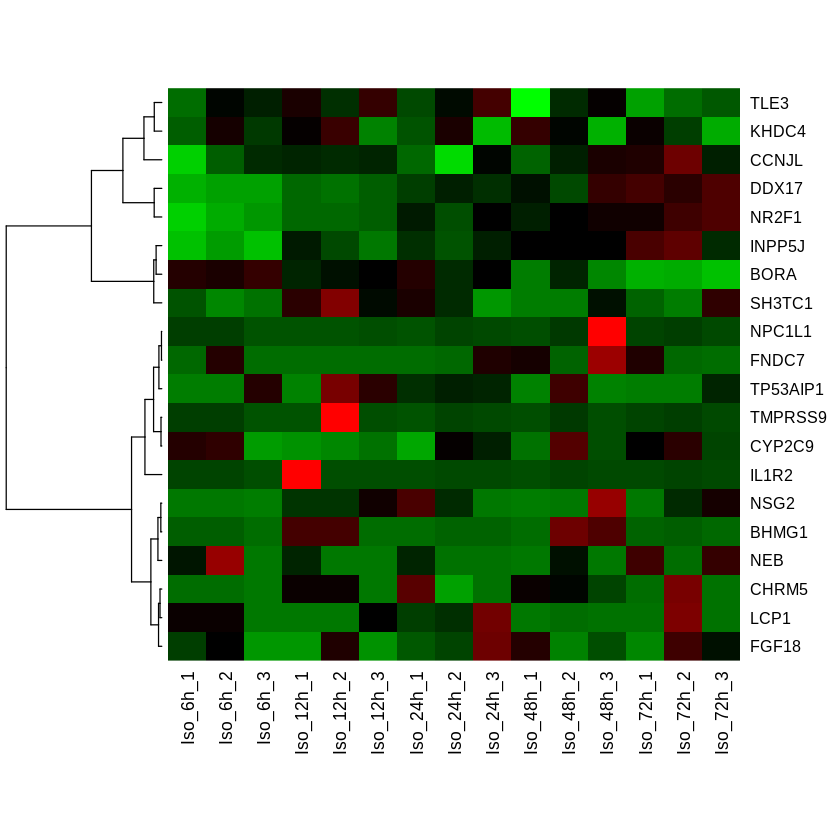

In [55]:
diffexpIDs.Iso <- as.character(rownames(topTable(fit.Iso, coef=2, number=20)))
diffexprows.Iso <- which(rownames(rlog.norm.counts.Iso) %in% diffexpIDs.Iso)
heatmap(rlog.norm.counts.Iso[diffexprows,], col=greenred(100), Rowv=T, Colv=NA, scale="row", labCol=colnames(rlog.norm.counts.Iso))

### Hypotonic Media

In [56]:
treatment.Hypo <- factor(gsub("Hypo_([0-9]+h)_[0-9]","\\1",colnames(rlog.norm.counts.Hypo)), 
                        levels=c("6h","12h","24h","48h","72h"))
design.Hypo <- model.matrix(~treatment.Hypo)
fit.Hypo <- lmFit(rlog.norm.counts.Hypo, design.Hypo)
fit.Hypo <- eBayes(fit.Hypo)
topTable(fit.Hypo, coef=2, adjust="fdr", number=15)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
KIDINS220,0.5751828,10.132172,23.63311,1.524206e-10,1.657359e-06,13.95456
NCOA1,0.5700527,9.444861,22.47685,2.574994e-10,1.657359e-06,13.56409
KLHL30,-0.4443689,1.869284,-22.34329,2.740343e-10,1.657359e-06,13.51694
H1F0,-1.7926280,4.266215,-20.66645,6.180400e-10,2.697734e-06,12.88578
SNPH,0.7266818,8.920936,20.30276,7.434233e-10,2.697734e-06,12.73865
E2F2,-1.3741390,7.697968,-17.89375,2.753379e-09,8.134499e-06,11.65816
GPR17,-0.3808056,1.508757,-17.66843,3.138310e-09,8.134499e-06,11.54675
MVB12B,0.8188378,9.016732,16.52428,6.254600e-09,1.300093e-05,10.95008
SRSF3,-1.2838184,11.361184,-16.47517,6.448872e-09,1.300093e-05,10.92326
SFN,-0.5439744,3.131738,-16.18703,7.729984e-09,1.371848e-05,10.76375


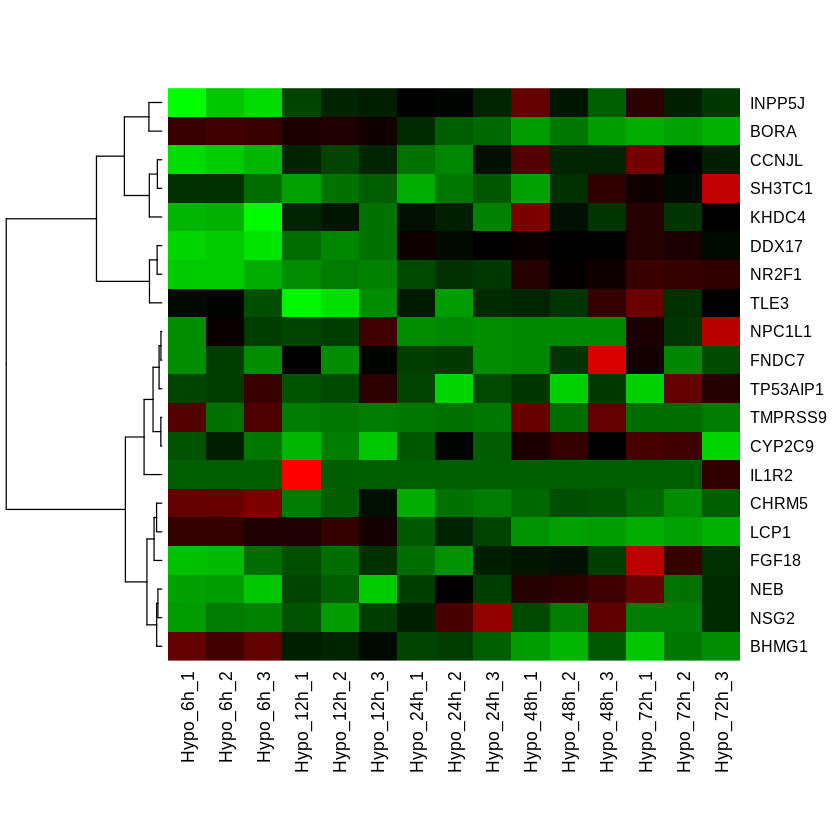

In [57]:
diffexpIDs.Hypo <- as.character(rownames(topTable(fit.Hypo, coef=2, number=20)))
diffexprows.Hypo <- which(rownames(rlog.norm.counts.Hypo) %in% diffexpIDs.Hypo)
heatmap(rlog.norm.counts.Hypo[diffexprows,], col=greenred(100), Rowv=T, Colv=NA, scale="row", labCol=colnames(rlog.norm.counts.Hypo))

### Hypertonic Media

In [58]:
treatment.Hyper <- factor(gsub("Hyper_([0-9]+h)_[0-9]","\\1",colnames(rlog.norm.counts.Hyper)), 
                        levels=c("6h","12h","24h","48h","72h"))
design.Hyper <- model.matrix(~treatment.Hyper)
fit.Hyper <- lmFit(rlog.norm.counts.Hyper, design.Hyper)
fit.Hyper <- eBayes(fit.Hyper)
topTable(fit.Hyper, coef=2, adjust="fdr", number=15)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
TP53AIP1,-0.8221886,1.518012,-34.02686,3.376155e-12,6.125696e-08,17.67313
MAFG,-1.1502100,11.073046,-31.03207,8.912360e-12,8.085293e-08,16.95067
NSG2,-1.0967991,1.818572,-26.49810,4.686384e-11,2.834325e-07,15.62330
NAT10,0.8500045,10.352132,24.31607,1.152859e-10,4.184902e-07,14.85963
PPCDC,0.6176010,7.487453,24.19482,1.214745e-10,4.184902e-07,14.81441
SYNC,0.9637655,10.360395,23.73366,1.485503e-10,4.184902e-07,14.63952
GPR39,1.4536152,8.506334,23.54524,1.614545e-10,4.184902e-07,14.56673
PPM1D,-1.3016027,8.870954,-22.75230,2.309006e-10,4.896804e-07,14.25158
DDX3X,-0.8329689,12.792015,-22.39525,2.723336e-10,4.896804e-07,14.10485
MYO7A,-0.7501758,2.237231,-22.06076,3.186033e-10,4.896804e-07,13.96457


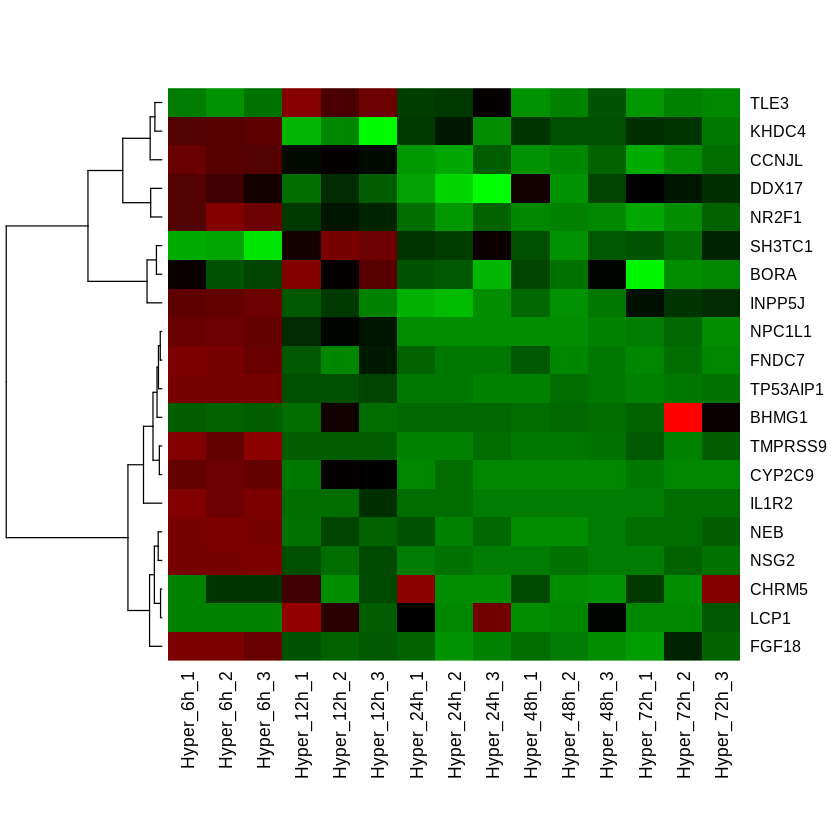

In [59]:
diffexpIDs.Hyper <- as.character(rownames(topTable(fit.Hyper, coef=2, number=20)))
diffexprows.Hyper <- which(rownames(rlog.norm.counts.Hyper) %in% diffexpIDs.Hyper)
heatmap(rlog.norm.counts.Hyper[diffexprows,], col=greenred(100), Rowv=T, Colv=NA, scale="row", labCol=colnames(rlog.norm.counts.Hyper))

### List of all genes

In [60]:
data.frame(Iso=sort(diffexpIDs.Iso),Hypo=sort(diffexpIDs.Hypo),Hyper=sort(diffexpIDs.Hyper))

Iso,Hypo,Hyper
AMPD2,CDC6,CHKA
CLEC4M,CDCA4,CRY1
DIRAS3,COG6,CSGALNACT2
FAM72A,COG8,DDX3X
LMNTD1,E2F2,E2F7
LOC105379752,GPR17,GPR39
LONRF3,H1F0,MAFG
MMP3,KIAA1671,MYO7A
NCCRP1,KIDINS220,NAT10
NDE1,KLHL30,NLRP1
